In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
def simulate_company(
    n_levels=4,
    levels=(0, 1, 2, 3),
    identities=("F", "M"),
    educations=("Bachelors", "Masters", "PhD"),
    n_target = [400, 100, 20, 5],
    max_time=200.0, 
    record_interval=5.0,       
    departure_rates=None,
    hiring_weights=None,
    promotion_weights=None,
    education_factor=None,
):
    if departure_rates is None:
        departure_rates = {
            (0, "F", "Bachelors"): 0.05, 
            (0, "F", "Masters"):   0.04,
            (0, "F", "PhD"):       0.03,

            (0, "M", "Bachelors"): 0.05, 
            (0, "M", "Masters"):   0.04,
            (0, "M", "PhD"):       0.03,

            (1, "F", "Bachelors"): 0.03,
            (1, "F", "Masters"):   0.025,
            (1, "F", "PhD"):       0.02,

            (1, "M", "Bachelors"): 0.03,
            (1, "M", "Masters"):   0.025,
            (1, "M", "PhD"):       0.02,

            (2, "F", "Bachelors"): 0.02,
            (2, "F", "Masters"):   0.015,
            (2, "F", "PhD"):       0.01,

            (2, "M", "Bachelors"): 0.02,
            (2, "M", "Masters"):   0.015,
            (2, "M", "PhD"):       0.01,

            (3, "F", "Bachelors"): 0.01,
            (3, "F", "Masters"):   0.008,
            (3, "F", "PhD"):       0.005,

            (3, "M", "Bachelors"): 0.01,
            (3, "M", "Masters"):   0.008,
            (3, "M", "PhD"):       0.005,
        }

    if hiring_weights is None:
        hiring_weights = {
            ("F", "Bachelors"): 0.5 * 0.5,   
            ("F", "Masters"):   0.5 * 0.4,   
            ("F", "PhD"):       0.5 * 0.1,   
            ("M", "Bachelors"): 0.5 * 0.5,   
            ("M", "Masters"):   0.5 * 0.4,   
            ("M", "PhD"):       0.5 * 0.1,   
        }


    if promotion_weights is None:
        promotion_weights = {
            1: {"F": 1.0, "M": 1.3},
            2: {"F": 1.0, "M": 1.3},
            3: {"F": 1.0, "M": 1.3}
        }

    if education_factor is None:
        education_factor = {
            "Bachelors": 1.0,
            "Masters": 1.2,
            "PhD": 1.5
        }


    X = {}
    for ell in levels:
        X[ell] = {}
        total_for_level = n_target[ell]
        n_categories = len(identities)*len(educations)
        base = total_for_level / n_categories
        for i in identities:
            for e in educations:
                X[ell][(i,e)] = int(base)
        assigned = sum(X[ell].values())
        diff = n_target[ell] - assigned
        if diff != 0:
            first_key = list(X[ell].keys())[0]
            X[ell][first_key] += diff

    current_time = 0.0
    next_record_time = 0.0


    recorded_times = []
    WPhD_L2_series = []
    WPhD_L3_series = []
    MMas_L2_series = []
    MMas_L3_series = []
    WPhD_levels_series = {ell: [] for ell in levels}
    MPhD_levels_series = {ell: [] for ell in levels}

    MBac_L2_series = []
    MBac_L3_series = []
    WBac_L2_series = []
    WBac_L3_series = []
    WMas_L2_series = []
    WMas_L3_series = []
    WPhD_L2_for_comp_series = [] 
    WPhD_L3_for_comp_series = []

    def record_state():
        recorded_times.append(current_time)
        WPhD_L2_series.append(X[2][("F","PhD")])
        WPhD_L3_series.append(X[3][("F","PhD")])
        MMas_L2_series.append(X[2][("M","Masters")])
        MMas_L3_series.append(X[3][("M","Masters")])

        for ell in levels:
            WPhD_levels_series[ell].append(X[ell][("F","PhD")])
            MPhD_levels_series[ell].append(X[ell][("M","PhD")])


        MBac_L2_series.append(X[2][("M","Bachelors")])
        MBac_L3_series.append(X[3][("M","Bachelors")])
        WBac_L2_series.append(X[2][("F","Bachelors")])
        WBac_L3_series.append(X[3][("F","Bachelors")])
        WMas_L2_series.append(X[2][("F","Masters")])
        WMas_L3_series.append(X[3][("F","Masters")])
        WPhD_L2_for_comp_series.append(X[2][("F","PhD")])
        WPhD_L3_for_comp_series.append(X[3][("F","PhD")])


    record_state()

    def get_total_rate_and_event_list():
        event_list = []
        total_rate = 0.0
        for ell in levels:
            for (i, e) in X[ell].keys():
                count = X[ell][(i,e)]
                if count > 0:
                    lam = departure_rates[(ell, i, e)]
                    rate_for_this_category = lam * count
                    if rate_for_this_category > 0:
                        event_list.append((ell, i, e, rate_for_this_category))
                        total_rate += rate_for_this_category
        return total_rate, event_list

    while current_time < max_time:
        total_rate, event_list = get_total_rate_and_event_list()
        if total_rate <= 0:
            break
        
        delta_t = np.random.exponential(1.0 / total_rate)
        new_time = current_time + delta_t
        if new_time > max_time:
            new_time = max_time
            delta_t = new_time - current_time

        r = random.random() * total_rate
        cumulative = 0.0
        chosen_ell, chosen_i, chosen_e = None, None, None
        for (ell, i, ee, cat_rate) in event_list:
            cumulative += cat_rate
            if r < cumulative:
                chosen_ell, chosen_i, chosen_e = ell, i, ee
                break


        X[chosen_ell][(chosen_i, chosen_e)] -= 1
        restore_levels(X, n_target, levels, identities, educations, promotion_weights, hiring_weights, education_factor)
        
        current_time = new_time


        if current_time >= next_record_time:
            record_state()
            next_record_time += record_interval


    if recorded_times[-1] < max_time:
        current_time = max_time
        record_state()


    return {
        "time": recorded_times,
        "WPhD_L2": WPhD_L2_series,
        "WPhD_L3": WPhD_L3_series,
        "MMas_L2": MMas_L2_series,
        "MMas_L3": MMas_L3_series,
        "WPhD_levels": WPhD_levels_series,
        "MPhD_levels": MPhD_levels_series,
        "MBac_L2": MBac_L2_series,
        "MBac_L3": MBac_L3_series,
        "WBac_L2": WBac_L2_series,
        "WBac_L3": WBac_L3_series,
        "WMas_L2": WMas_L2_series,
        "WMas_L3": WMas_L3_series,
        "WPhD_L2_for_comp": WPhD_L2_for_comp_series,
        "WPhD_L3_for_comp": WPhD_L3_for_comp_series
    }

In [ ]:
def restore_levels(X, n_target, levels, identities, educations, promotion_weights, hiring_weights, education_factor):
    changed = True
    while changed:
        changed = False
        for ell in sorted(levels):
            current_count = sum(X[ell].values())
            if current_count < n_target[ell]:
                deficit = n_target[ell] - current_count
                if ell == 0:
                    # Hire deficit employees at level 0
                    for _ in range(deficit):
                        hw_sum = sum(hiring_weights.values())
                        draw = random.random() * hw_sum
                        cum = 0.0
                        new_i, new_e = None, None
                        for (ii, ee), w in hiring_weights.items():
                            cum += w
                            if draw < cum:
                                new_i, new_e = ii, ee
                                break
                        X[0][(new_i, new_e)] += 1
                else:
                    from_level = ell - 1
                    for _ in range(deficit):
                        candidates = []
                        sum_w = 0.0
                        for (ii, ee), cnt in X[from_level].items():
                            if cnt > 0:
                                w = promotion_weights[ell][ii] * education_factor[ee] * cnt
                                if w > 0:
                                    candidates.append((ii, ee, w))
                                    sum_w += w
                        if sum_w == 0:
                            break
                        draw = random.random() * sum_w
                        cum = 0.0
                        chosen_i, chosen_e = None, None
                        for (ii, ee, w) in candidates:
                            cum += w
                            if draw < cum:
                                chosen_i, chosen_e = ii, ee
                                break
                        X[from_level][(chosen_i, chosen_e)] -= 1
                        X[ell][(chosen_i, chosen_e)] += 1
                changed = True

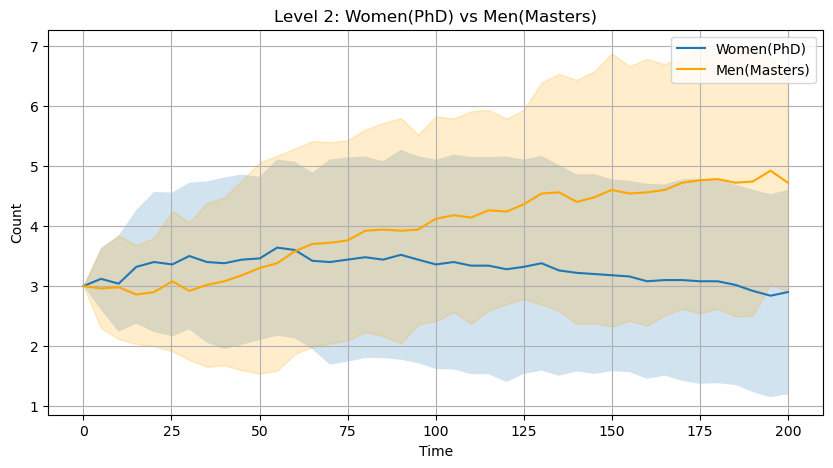

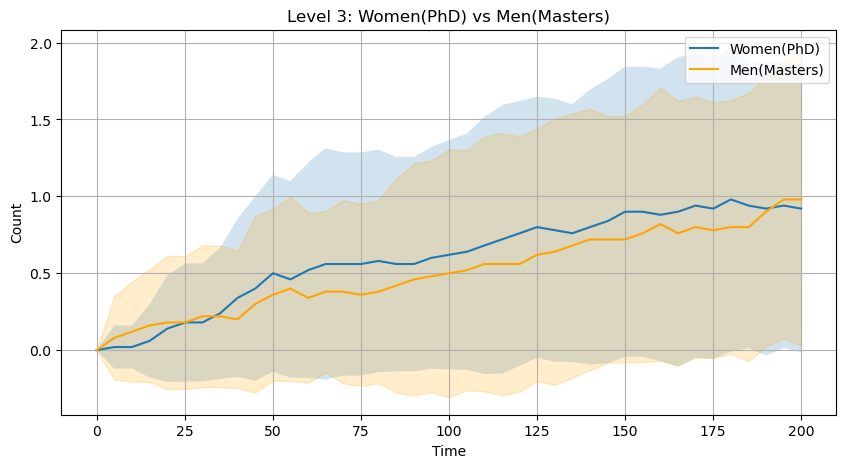

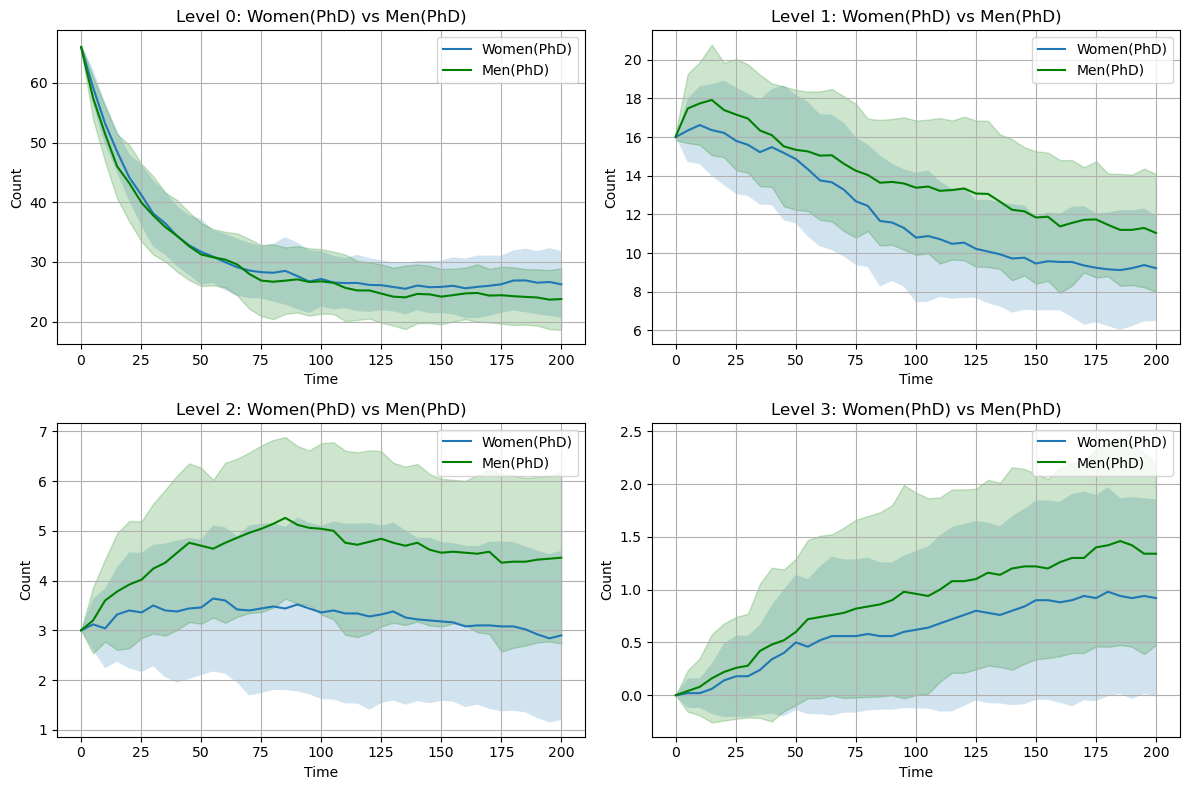

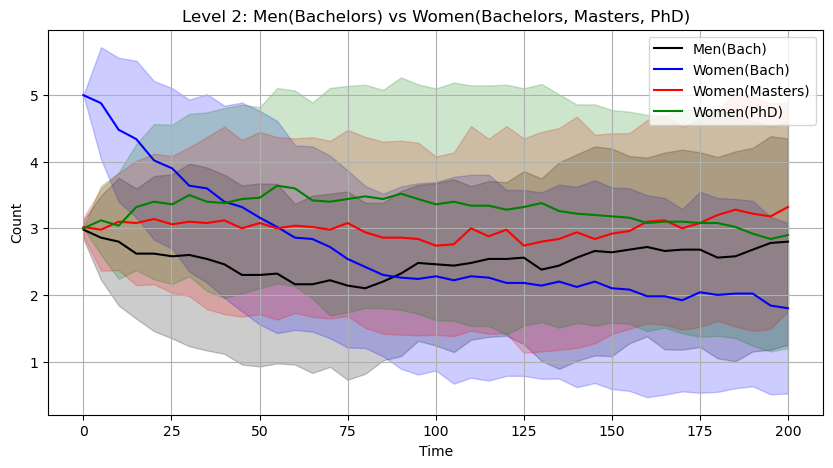

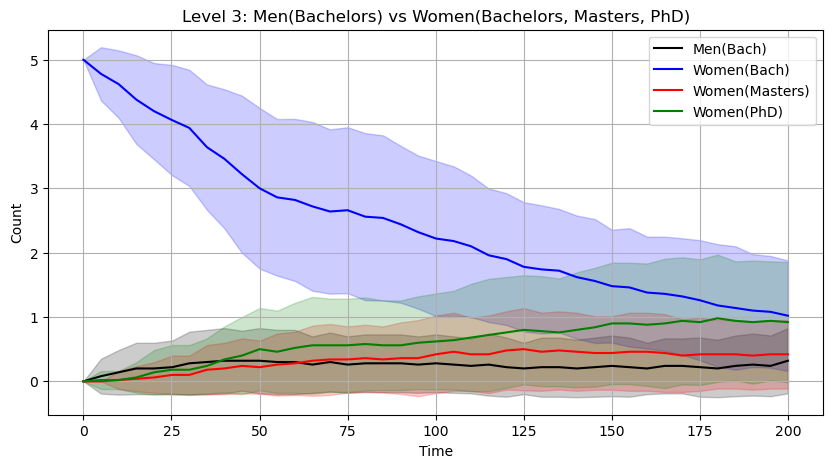

Final statistics at time = 200.0:
Women(PhD) at Level 2: Mean = 2.90, Std = 1.70
Men(Masters) at Level 2: Mean = 4.72, Std = 1.81
Women(PhD) at Level 3: Mean = 0.92, Std = 0.93
Men(Masters) at Level 3: Mean = 0.98, Std = 0.95
Level 0 Women(PhD): Mean=26.24, Std=5.58; Men(PhD): Mean=23.78, Std=5.18
Level 1 Women(PhD): Mean=9.22, Std=2.74; Men(PhD): Mean=11.04, Std=3.05
Level 2 Women(PhD): Mean=2.90, Std=1.70; Men(PhD): Mean=4.46, Std=1.72
Level 3 Women(PhD): Mean=0.92, Std=0.93; Men(PhD): Mean=1.34, Std=0.86

At Level 2 (final):
Men(Bach): Mean=2.80, Std=1.55
Women(Bach): Mean=1.80, Std=1.28
Women(Masters): Mean=3.32, Std=1.57
Women(PhD): Mean=2.90, Std=1.70

At Level 3 (final):
Men(Bach): Mean=0.32, Std=0.51
Women(Bach): Mean=1.02, Std=0.86
Women(Masters): Mean=0.42, Std=0.53
Women(PhD): Mean=0.92, Std=0.93


In [6]:
def run_multiple_simulations(num_runs=100, max_time=200.0, record_interval=5.0):
    all_times = None
    WPhD_L2_all = []
    WPhD_L3_all = []
    MMas_L2_all = []
    MMas_L3_all = []
    WPhD_levels_all = defaultdict(list)
    MPhD_levels_all = defaultdict(list)

    MBac_L2_all = []
    MBac_L3_all = []
    WBac_L2_all = []
    WBac_L3_all = []
    WMas_L2_all = []
    WMas_L3_all = []
    WPhD_L2_comp_all = []
    WPhD_L3_comp_all = []

    for run_id in range(num_runs):
        results = simulate_company(max_time=max_time, record_interval=record_interval)
        if all_times is None:
            all_times = results["time"]
        WPhD_L2_all.append(results["WPhD_L2"])
        WPhD_L3_all.append(results["WPhD_L3"])
        MMas_L2_all.append(results["MMas_L2"])
        MMas_L3_all.append(results["MMas_L3"])

        for ell in (0,1,2,3):
            WPhD_levels_all[ell].append(results["WPhD_levels"][ell])
            MPhD_levels_all[ell].append(results["MPhD_levels"][ell])

        MBac_L2_all.append(results["MBac_L2"])
        MBac_L3_all.append(results["MBac_L3"])
        WBac_L2_all.append(results["WBac_L2"])
        WBac_L3_all.append(results["WBac_L3"])
        WMas_L2_all.append(results["WMas_L2"])
        WMas_L3_all.append(results["WMas_L3"])
        WPhD_L2_comp_all.append(results["WPhD_L2_for_comp"])
        WPhD_L3_comp_all.append(results["WPhD_L3_for_comp"])

    def to_arr(list_of_lists):
        return np.array(list_of_lists)

    WPhD_L2_arr = to_arr(WPhD_L2_all)
    WPhD_L3_arr = to_arr(WPhD_L3_all)
    MMas_L2_arr = to_arr(MMas_L2_all)
    MMas_L3_arr = to_arr(MMas_L3_all)

    WPhD_L2_mean, WPhD_L2_std = WPhD_L2_arr.mean(axis=0), WPhD_L2_arr.std(axis=0)
    WPhD_L3_mean, WPhD_L3_std = WPhD_L3_arr.mean(axis=0), WPhD_L3_arr.std(axis=0)
    MMas_L2_mean, MMas_L2_std = MMas_L2_arr.mean(axis=0), MMas_L2_arr.std(axis=0)
    MMas_L3_mean, MMas_L3_std = MMas_L3_arr.mean(axis=0), MMas_L3_arr.std(axis=0)

    WPhD_levels_mean = {}
    WPhD_levels_std = {}
    MPhD_levels_mean = {}
    MPhD_levels_std = {}

    for ell in (0,1,2,3):
        WPhD_ell_arr = to_arr(WPhD_levels_all[ell])
        MPhD_ell_arr = to_arr(MPhD_levels_all[ell])
        WPhD_levels_mean[ell] = WPhD_ell_arr.mean(axis=0)
        WPhD_levels_std[ell] = WPhD_ell_arr.std(axis=0)
        MPhD_levels_mean[ell] = MPhD_ell_arr.mean(axis=0)
        MPhD_levels_std[ell] = MPhD_ell_arr.std(axis=0)

    # New arrays for M(Bachelors) and W(Bachelors, Masters, PhD) at L2 and L3
    MBac_L2_arr = to_arr(MBac_L2_all)
    MBac_L3_arr = to_arr(MBac_L3_all)
    WBac_L2_arr = to_arr(WBac_L2_all)
    WBac_L3_arr = to_arr(WBac_L3_all)
    WMas_L2_arr = to_arr(WMas_L2_all)
    WMas_L3_arr = to_arr(WMas_L3_all)
    WPhD_L2_comp_arr = to_arr(WPhD_L2_comp_all)
    WPhD_L3_comp_arr = to_arr(WPhD_L3_comp_all)

    MBac_L2_mean, MBac_L2_std = MBac_L2_arr.mean(axis=0), MBac_L2_arr.std(axis=0)
    MBac_L3_mean, MBac_L3_std = MBac_L3_arr.mean(axis=0), MBac_L3_arr.std(axis=0)
    WBac_L2_mean, WBac_L2_std = WBac_L2_arr.mean(axis=0), WBac_L2_arr.std(axis=0)
    WBac_L3_mean, WBac_L3_std = WBac_L3_arr.mean(axis=0), WBac_L3_arr.std(axis=0)
    WMas_L2_mean, WMas_L2_std = WMas_L2_arr.mean(axis=0), WMas_L2_arr.std(axis=0)
    WMas_L3_mean, WMas_L3_std = WMas_L3_arr.mean(axis=0), WMas_L3_arr.std(axis=0)
    WPhD_L2_comp_mean, WPhD_L2_comp_std = WPhD_L2_comp_arr.mean(axis=0), WPhD_L2_comp_arr.std(axis=0)
    WPhD_L3_comp_mean, WPhD_L3_comp_std = WPhD_L3_comp_arr.mean(axis=0), WPhD_L3_comp_arr.std(axis=0)


    # Women(PhD) vs Men(Masters) at L2
    plt.figure(figsize=(10,5))
    plt.title("Level 2: Women(PhD) vs Men(Masters)")
    plt.plot(all_times, WPhD_L2_mean, label="Women(PhD)")
    plt.fill_between(all_times, WPhD_L2_mean - WPhD_L2_std, WPhD_L2_mean + WPhD_L2_std, alpha=0.2)
    plt.plot(all_times, MMas_L2_mean, label="Men(Masters)", color="orange")
    plt.fill_between(all_times, MMas_L2_mean - MMas_L2_std, MMas_L2_mean + MMas_L2_std, alpha=0.2, color="orange")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Women(PhD) vs Men(Masters) at L3
    plt.figure(figsize=(10,5))
    plt.title("Level 3: Women(PhD) vs Men(Masters)")
    plt.plot(all_times, WPhD_L3_mean, label="Women(PhD)")
    plt.fill_between(all_times, WPhD_L3_mean - WPhD_L3_std, WPhD_L3_mean + WPhD_L3_std, alpha=0.2)
    plt.plot(all_times, MMas_L3_mean, label="Men(Masters)", color="orange")
    plt.fill_between(all_times, MMas_L3_mean - MMas_L3_std, MMas_L3_mean + MMas_L3_std, alpha=0.2, color="orange")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Women(PhD) vs Men(PhD) at all levels
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    axes = axes.flatten()

    for idx, ell in enumerate((0,1,2,3)):
        ax = axes[idx]
        ax.set_title(f"Level {ell}: Women(PhD) vs Men(PhD)")
        W_mean, W_std = WPhD_levels_mean[ell], WPhD_levels_std[ell]
        M_mean, M_std = MPhD_levels_mean[ell], MPhD_levels_std[ell]

        ax.plot(all_times, W_mean, label="Women(PhD)")
        ax.fill_between(all_times, W_mean - W_std, W_mean + W_std, alpha=0.2)
        ax.plot(all_times, M_mean, label="Men(PhD)", color="green")
        ax.fill_between(all_times, M_mean - M_std, M_mean + M_std, alpha=0.2, color="green")
        ax.set_xlabel("Time")
        ax.set_ylabel("Count")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Compare Men(Bachelors) vs Women(Bachelors, Masters, PhD) at level 2
    plt.figure(figsize=(10,5))
    plt.title("Level 2: Men(Bachelors) vs Women(Bachelors, Masters, PhD)")
    plt.plot(all_times, MBac_L2_mean, label="Men(Bach)", color="black")
    plt.fill_between(all_times, MBac_L2_mean - MBac_L2_std, MBac_L2_mean + MBac_L2_std, color="black", alpha=0.2)

    plt.plot(all_times, WBac_L2_mean, label="Women(Bach)", color="blue")
    plt.fill_between(all_times, WBac_L2_mean - WBac_L2_std, WBac_L2_mean + WBac_L2_std, color="blue", alpha=0.2)

    plt.plot(all_times, WMas_L2_mean, label="Women(Masters)", color="red")
    plt.fill_between(all_times, WMas_L2_mean - WMas_L2_std, WMas_L2_mean + WMas_L2_std, color="red", alpha=0.2)

    plt.plot(all_times, WPhD_L2_comp_mean, label="Women(PhD)", color="green")
    plt.fill_between(all_times, WPhD_L2_comp_mean - WPhD_L2_comp_std, WPhD_L2_comp_mean + WPhD_L2_comp_std, color="green", alpha=0.2)

    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Compare Men(Bachelors) vs Women(Bachelors, Masters, PhD) at level 3
    plt.figure(figsize=(10,5))
    plt.title("Level 3: Men(Bachelors) vs Women(Bachelors, Masters, PhD)")
    plt.plot(all_times, MBac_L3_mean, label="Men(Bach)", color="black")
    plt.fill_between(all_times, MBac_L3_mean - MBac_L3_std, MBac_L3_mean + MBac_L3_std, color="black", alpha=0.2)

    plt.plot(all_times, WBac_L3_mean, label="Women(Bach)", color="blue")
    plt.fill_between(all_times, WBac_L3_mean - WBac_L3_std, WBac_L3_mean + WBac_L3_std, color="blue", alpha=0.2)

    plt.plot(all_times, WMas_L3_mean, label="Women(Masters)", color="red")
    plt.fill_between(all_times, WMas_L3_mean - WMas_L3_std, WMas_L3_mean + WMas_L3_std, color="red", alpha=0.2)

    plt.plot(all_times, WPhD_L3_comp_mean, label="Women(PhD)", color="green")
    plt.fill_between(all_times, WPhD_L3_comp_mean - WPhD_L3_comp_std, WPhD_L3_comp_mean + WPhD_L3_comp_std, color="green", alpha=0.2)

    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.grid(True)
    plt.legend()
    plt.show()

    # final statistics:
    idx = -1
    print("Final statistics at time = {}:".format(max_time))
    print("Women(PhD) at Level 2: Mean = {:.2f}, Std = {:.2f}".format(WPhD_L2_mean[idx], WPhD_L2_std[idx]))
    print("Men(Masters) at Level 2: Mean = {:.2f}, Std = {:.2f}".format(MMas_L2_mean[idx], MMas_L2_std[idx]))
    print("Women(PhD) at Level 3: Mean = {:.2f}, Std = {:.2f}".format(WPhD_L3_mean[idx], WPhD_L3_std[idx]))
    print("Men(Masters) at Level 3: Mean = {:.2f}, Std = {:.2f}".format(MMas_L3_mean[idx], MMas_L3_std[idx]))

    for ell in (0,1,2,3):
        W_mean, W_std = WPhD_levels_mean[ell][idx], WPhD_levels_std[ell][idx]
        M_mean, M_std = MPhD_levels_mean[ell][idx], MPhD_levels_std[ell][idx]
        print(f"Level {ell} Women(PhD): Mean={W_mean:.2f}, Std={W_std:.2f}; Men(PhD): Mean={M_mean:.2f}, Std={M_std:.2f}")

    print("\nAt Level 2 (final):")
    print(f"Men(Bach): Mean={MBac_L2_mean[idx]:.2f}, Std={MBac_L2_std[idx]:.2f}")
    print(f"Women(Bach): Mean={WBac_L2_mean[idx]:.2f}, Std={WBac_L2_std[idx]:.2f}")
    print(f"Women(Masters): Mean={WMas_L2_mean[idx]:.2f}, Std={WMas_L2_std[idx]:.2f}")
    print(f"Women(PhD): Mean={WPhD_L2_comp_mean[idx]:.2f}, Std={WPhD_L2_comp_std[idx]:.2f}")

    print("\nAt Level 3 (final):")
    print(f"Men(Bach): Mean={MBac_L3_mean[idx]:.2f}, Std={MBac_L3_std[idx]:.2f}")
    print(f"Women(Bach): Mean={WBac_L3_mean[idx]:.2f}, Std={WBac_L3_std[idx]:.2f}")
    print(f"Women(Masters): Mean={WMas_L3_mean[idx]:.2f}, Std={WMas_L3_std[idx]:.2f}")
    print(f"Women(PhD): Mean={WPhD_L3_comp_mean[idx]:.2f}, Std={WPhD_L3_comp_std[idx]:.2f}")


def main():
    run_multiple_simulations(num_runs=50, max_time=200.0, record_interval=5.0)

if __name__ == "__main__":
    main()
